<a href="https://colab.research.google.com/github/mithil2311/Time_Series_Stock_Price_Forecast_/blob/version1/V12Time_Series_Stock_Price_Forecast_using_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics

plt.style.use("ggplot")

%matplotlib inline

In [0]:
plt.rcParams["figure.figsize"] = (12, 6)

Download stock price data from NSE [website](https://www.nseindia.com/products/content/equities/equities/eq_security.htm). Here I download stock price data for TCS stock.


In [0]:
df = pd.read_csv("tcsstock.csv")
df.head()



,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty
0,TCS,EQ,21-Aug-2017,2513.80,2505.5,2549.00,2494.30,2513.20,2528.80,2534.62,1152417,2.920942e+09,54265,747946,64.90
1,TCS,EQ,22-Aug-2017,2528.80,2523.0,2539.50,2492.00,2500.00,2497.55,2516.08,565663,1.423252e+09,35029,287383,50.80
2,TCS,EQ,23-Aug-2017,2497.55,2505.0,2516.80,2473.15,2491.60,2489.45,2487.52,781136,1.943094e+09,39129,512785,65.65
3,TCS,EQ,24-Aug-2017,2489.45,2497.7,2517.95,2486.15,2498.05,2496.60,2495.82,811954,2.026487e+09,42614,596982,73.52
4,TCS,EQ,28-Aug-2017,2496.60,2504.6,2505.40,2461.00,2491.00,2487.30,2479.76,1018398,2.525379e+09,54931,696983,68.44


Check whether you have duplicate data on by date. It looks like 11/2/2019, 18/2/2019, 25/2/2019 etc. have duplicate data. Not sure why there are duplicates by date. It could be ammendment to the data.

In [0]:
df[df["Date"].duplicated(keep = False)]

,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty
366,TCS,BL,11-Feb-2019,2604.20,2061.40,2061.40,2061.40,2061.40,2061.40,2061.40,376308,7.757213e+08,1,0,0.00
367,TCS,EQ,11-Feb-2019,2061.40,2060.00,2096.00,2048.90,2065.60,2065.90,2077.11,1778730,3.694622e+09,83603,901516,50.68
372,TCS,BL,18-Feb-2019,2061.40,2029.70,2029.70,2029.70,2029.70,2029.70,2029.70,2474600,5.022696e+09,1,0,0.00
373,TCS,EQ,18-Feb-2019,2029.70,2037.60,2041.95,1962.65,1969.60,1970.30,1988.87,2942184,5.851634e+09,100585,1668905,56.72
378,TCS,BL,25-Feb-2019,2029.70,1925.65,1925.65,1925.65,1925.65,1925.65,1925.65,1057509,2.036392e+09,2,0,0.00
379,TCS,EQ,25-Feb-2019,1925.65,1932.50,1990.00,1930.50,1987.00,1985.15,1961.61,2934880,5.757095e+09,140541,1341508,45.71
396,TCS,BL,22-Mar-2019,1925.65,2015.05,2015.05,2015.05,2015.05,2015.05,2015.05,264913,5.338129e+08,1,264913,100.00
397,TCS,EQ,22-Mar-2019,2015.05,2015.00,2016.00,1983.30,2010.00,2005.65,1998.96,3148149,6.293032e+09,155770,1787595,56.78


Drop the duplicate from the dataset.

In [0]:
df = df[~df["Date"].duplicated()]

Convert the dataset into time series data by undating the index to time series index. 

In [0]:
df.index = pd.to_datetime(df["Date"])
df.head()

,Symbol,Series,Date,Prev Close,Open Price,High Price,Low Price,Last Price,Close Price,Average Price,Total Traded Quantity,Turnover,No. of Trades,Deliverable Qty,% Dly Qt to Traded Qty
Date,,,,,,,,,,,,,,,
2017-08-21,TCS,EQ,21-Aug-2017,2513.80,2505.5,2549.00,2494.30,2513.20,2528.80,2534.62,1152417,2.920942e+09,54265,747946,64.90
2017-08-22,TCS,EQ,22-Aug-2017,2528.80,2523.0,2539.50,2492.00,2500.00,2497.55,2516.08,565663,1.423252e+09,35029,287383,50.80
2017-08-23,TCS,EQ,23-Aug-2017,2497.55,2505.0,2516.80,2473.15,2491.60,2489.45,2487.52,781136,1.943094e+09,39129,512785,65.65
2017-08-24,TCS,EQ,24-Aug-2017,2489.45,2497.7,2517.95,2486.15,2498.05,2496.60,2495.82,811954,2.026487e+09,42614,596982,73.52
2017-08-28,TCS,EQ,28-Aug-2017,2496.60,2504.6,2505.40,2461.00,2491.00,2487.30,2479.76,1018398,2.525379e+09,54931,696983,68.44


In [0]:
df.index

DatetimeIndex(['2017-08-21', '2017-08-22', '2017-08-23', '2017-08-24',
               '2017-08-28', '2017-08-29', '2017-08-30', '2017-08-31',
               '2017-09-01', '2017-09-04',
               ...
               '2019-08-02', '2019-08-05', '2019-08-06', '2019-08-07',
               '2019-08-08', '2019-08-09', '2019-08-13', '2019-08-14',
               '2019-08-16', '2019-08-19'],
              dtype='datetime64[ns]', name='Date', length=497, freq=None)

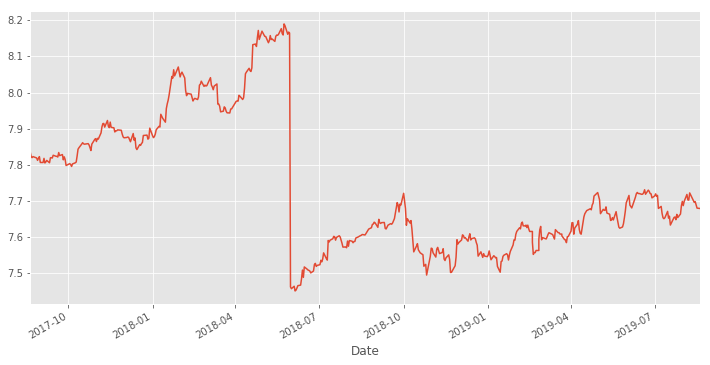

In [0]:
y = np.log(df["Close Price"])
y.plot()

In [0]:
y.index

DatetimeIndex(['2017-08-21', '2017-08-22', '2017-08-23', '2017-08-24',
               '2017-08-28', '2017-08-29', '2017-08-30', '2017-08-31',
               '2017-09-01', '2017-09-04',
               ...
               '2019-08-02', '2019-08-05', '2019-08-06', '2019-08-07',
               '2019-08-08', '2019-08-09', '2019-08-13', '2019-08-14',
               '2019-08-16', '2019-08-19'],
              dtype='datetime64[ns]', name='Date', length=497, freq=None)

Let's see if there are gaps in the data in terms of date range. Trading does not happen on weekends or national holidays. So there is no data on those days. 

In [0]:
list(y.index[:10])

[Timestamp('2017-08-21 00:00:00'),
 Timestamp('2017-08-22 00:00:00'),
 Timestamp('2017-08-23 00:00:00'),
 Timestamp('2017-08-24 00:00:00'),
 Timestamp('2017-08-28 00:00:00'),
 Timestamp('2017-08-29 00:00:00'),
 Timestamp('2017-08-30 00:00:00'),
 Timestamp('2017-08-31 00:00:00'),
 Timestamp('2017-09-01 00:00:00'),
 Timestamp('2017-09-04 00:00:00')]

In [0]:
y.asfreq("D")[:15]

ValueError: ignored

Let's impute the missing data by forward fill using asfreq method.

In [0]:
y.asfreq("D", method="ffill")[:15]

ValueError: ignored

For legitimate gaps, we can also set frequency to business days ("B")

In [0]:
y = y.asfreq("B")
y.index

ValueError: ignored

Calculate quarterly high, low etc. 

In [0]:
pd.DataFrame(dict(low=y.resample("Q").min(), 
                  high=y.resample("Q").max(), 
                  first = y.resample("Q").first(), 
                  last = y.resample("Q").last(),
                  median = y.resample("Q").median(),
                  mean = y.resample("Q").mean()
                 ))

,low,high,first,last,median,mean
Date,,,,,,
2017-09-30,7.798092,7.835500,7.835500,7.798092,7.819415,7.818055
2017-12-31,7.795482,7.922605,7.803210,7.901451,7.871711,7.868971
2018-03-31,7.875195,8.070547,7.880653,7.954776,7.985789,7.983002
2018-06-30,7.451009,8.189716,7.975788,7.521724,8.057124,7.897523
2018-09-30,7.523670,7.695508,7.523670,7.688776,7.602676,7.607829
2018-12-31,7.495042,7.721149,7.721149,7.545945,7.567837,7.572861
2019-03-31,7.502876,7.641516,7.551082,7.601727,7.594016,7.586639
2019-06-30,7.608126,7.731031,7.616604,7.708500,7.674339,7.675082
2019-09-30,7.633345,7.722279,7.714030,7.679251,7.679760,7.680289


Calculate rolling mean, exponentially weighted mean

In [0]:
period = 3
y_rolling = pd.DataFrame(dict(actual = y, 
                              rolling_mean = y.rolling(period).mean(), 
                              ewm = y.ewm(span = period).mean()
                             ))
y_rolling.head(10)

,actual,rolling_mean,ewm
Date,,,
2017-08-21,7.835500,NaN,7.835500
2017-08-22,7.823066,NaN,7.827210
2017-08-23,7.819817,7.826128,7.822986
2017-08-24,7.822685,7.821856,7.822825
2017-08-28,7.818953,7.820485,7.820827
2017-08-29,7.812317,7.817985,7.816505
2017-08-30,7.817847,7.816372,7.817181
2017-08-31,7.822585,7.817583,7.819894
2017-09-01,7.806472,7.815635,7.813170


In [0]:
rolling_dropped = y_rolling.dropna()
print("rmse over rolling mean: ", metrics.mean_squared_error(rolling_dropped.actual, rolling_dropped.rolling_mean) ** 0.5)
print("rmse over ewma: ", metrics.mean_squared_error(rolling_dropped.actual, rolling_dropped["ewm"]) ** 0.5)

rmse over rolling mean:  0.026011645671137767
rmse over ewma:  0.020170973630761466


By visual inspection, we see the time series is not stationary. Let we will see a more formal way of testing using Dickey Fullter Test. 

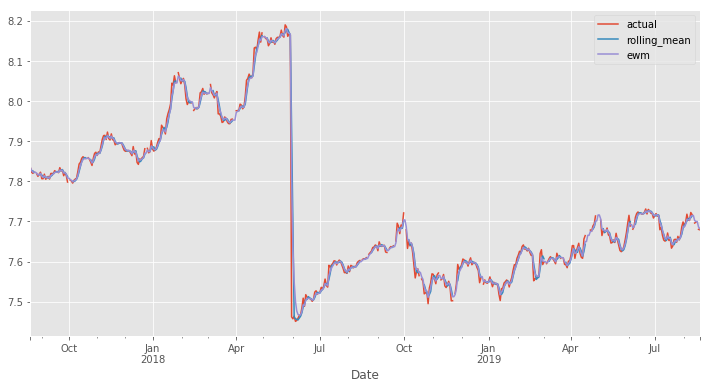

In [0]:
y_rolling.plot()

Formal of way of test for stationarity. Since the p-value of Augmented Dickey Fullter test is > 0.05, we can say that there is not sufficient proof that the time series is stationary. Loosely speaking, it is non-stationary. We need further transformation to make data stationary. Populary method for making data stationary will be to take "difference". Taking difference by lag one, we see the p-val for Dickey Fuller test is < 0.05. So we conclude, diff 1 has made the data stationary. 

In [0]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(y.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.089879
p-value: 0.248604


In [0]:
diff = pd.DataFrame({"actual": y, "diff1": y.diff(3)}).head(10)
diff["diff2"] = diff.diff1.diff(1)
diff

,actual,diff1,diff2
Date,,,
2017-08-21,7.835500,NaN,NaN
2017-08-22,7.823066,NaN,NaN
2017-08-23,7.819817,NaN,NaN
2017-08-24,7.822685,-0.012815,NaN
2017-08-28,7.818953,-0.004112,0.008703
2017-08-29,7.812317,-0.007500,-0.003387
2017-08-30,7.817847,-0.004838,0.002661
2017-08-31,7.822585,0.003632,0.008470
2017-09-01,7.806472,-0.005845,-0.009477


In [0]:
result = adfuller(y.diff(periods=1).dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -22.010132
p-value: 0.000000


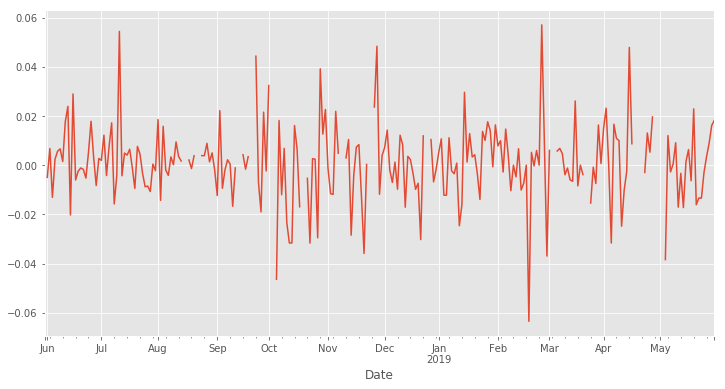

In [0]:
y.diff(periods=1).plot()

Use pandas's auto correlation plot. Here is a nice explanation of the [autocorrelation plot](https://stats.stackexchange.com/questions/357300/what-does-pandas-autocorrelation-graph-show) 

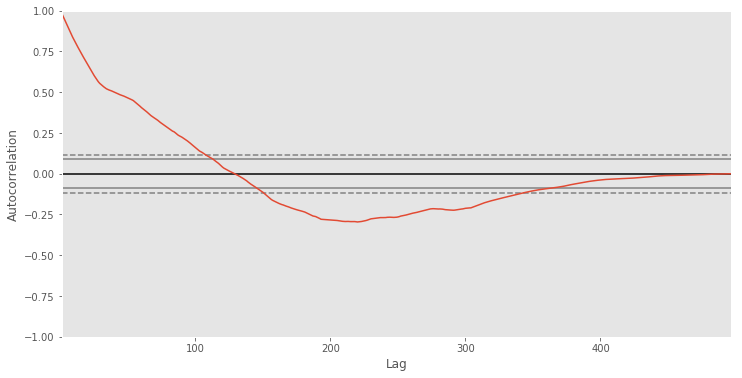

In [0]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(y)

In [0]:
y = y.dropna()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                  0
count  4.960000e+02
mean  -2.440217e-07
std    3.470745e-02
min   -6.997434e-01
25%   -6.616759e-03
50%    1.259251e-03
75%    9.290906e-03
max    6.459249e-02


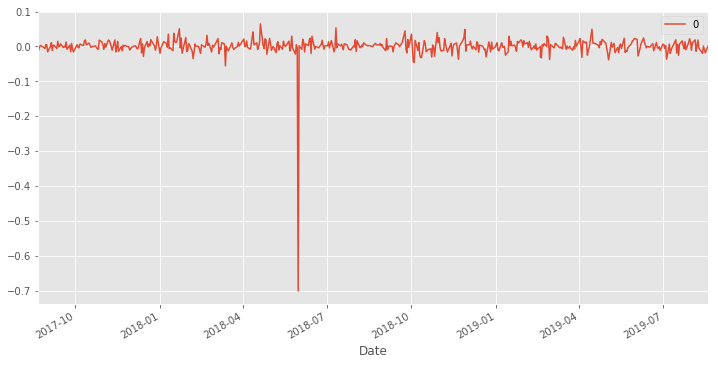

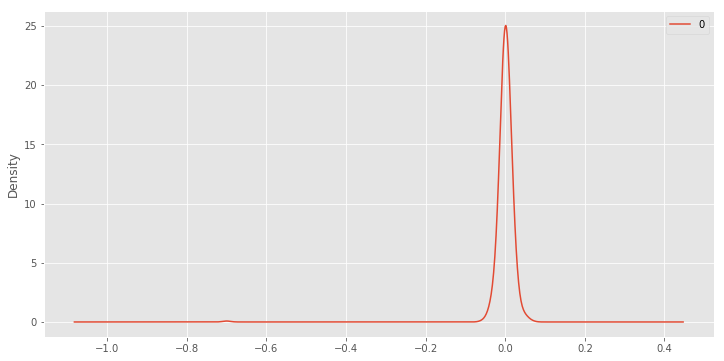

In [0]:
from statsmodels.tsa.arima_model import ARIMA

# fit model
model = ARIMA(y, order=(5,1,0)) # p, d, q
model_fit = model.fit(disp=0)
#print(model_fit.summary())

# plot residual erros
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

In [0]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Close Price   No. Observations:                  496
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 963.658
Method:                       css-mle   S.D. of innovations              0.035
Date:                Tue, 27 Aug 2019   AIC                          -1913.316
Time:                        08:09:13   BIC                          -1883.870
Sample:                             1   HQIC                         -1901.758
                                                                              
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0003      0.002     -0.198      0.843      -0.003       0.003
ar.L1.D.Close Price     0.0099      0.045      0.221      0.825      -0.078       0.098
ar.L2.D.Close Price    -0.0209      0.045     -0.467      0.641      -0.109       0.067
ar.L3.D.Close Price     0.0473      0.045      1.058      0.291      -0.040       0.135
ar.L4.D.Close Price     0.0117      0.045      0.262      0.793      -0.076       0.099
ar.L5.D.Close Price    -0.0298      0.045     -0.668      0.505      -0.117       0.058
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.1384           -0.0000j            2.1384           -0.5000
AR.2           -0.5679           -1.7681j            1.8570           -0.2995
AR.3           -0.5679           +1.7681j            1.8570            0.2995
AR.4            1.8337           -1.0874j            2.1319           -0.0852
AR.5            1.8337           +1.0874j            2.1319            0.0852
-----------------------------------------------------------------------------
"""

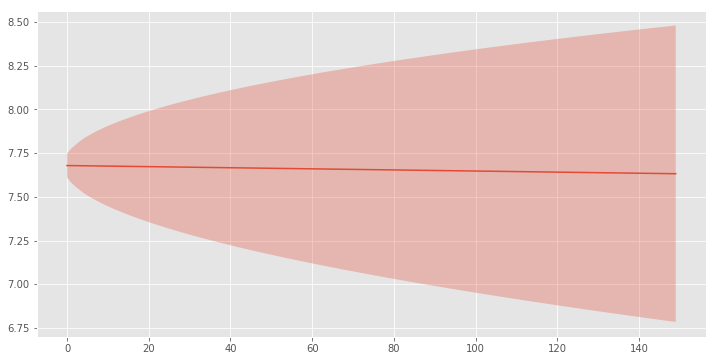

In [0]:
model = ARIMA(y.values, order=(5,1,0))
model_fit = model.fit(disp=0)
predictions, error, conf_interval = model_fit.forecast(150)
plt.plot(predictions)
plt.fill_between(range(len(predictions)), conf_interval[:,0], conf_interval[:,1], alpha = 0.3)

In [0]:
predictions[:10]

array([7.67932592, 7.67884233, 7.67820371, 7.67842813, 7.67814245,
       7.67778862, 7.67750043, 7.67720495, 7.67687305, 7.67655848])

In [0]:
error[:10]

array([0.03491566, 0.04955365, 0.06032908, 0.07029372, 0.07920573,
       0.08670896, 0.09363003, 0.10010547, 0.10615035, 0.11186028])

In [0]:
conf_interval[:10]

array([[7.61093841, 7.7478053 ],
       [7.58181229, 7.77605902],
       [7.56005655, 7.79654219],
       [7.54080732, 7.81635363],
       [7.52305594, 7.83353671],
       [7.50799018, 7.84788305],
       [7.49413737, 7.86116035],
       [7.48114964, 7.87355586],
       [7.46896407, 7.88506579],
       [7.45745615, 7.89594038]])

In [0]:
model.endog

array([-1.24346306e-02, -3.24844882e-03,  2.86800369e-03, -3.73202143e-03,
       -6.63556381e-03,  5.52933564e-03,  4.73810840e-03, -1.61124468e-02,
       -1.01778063e-04,  1.13956157e-02, -1.26177611e-02,  2.80870475e-03,
        4.25903660e-03, -6.55833256e-03,  1.37573231e-02,  3.01347023e-04,
       -9.04313637e-04,  7.65074831e-03, -2.79714873e-03, -3.20172896e-04,
       -1.88308882e-03,  1.24940600e-02, -8.47176191e-03,  2.85181722e-03,
       -1.44825414e-02,  8.18975732e-03, -7.46264615e-03, -1.64892589e-02,
        5.11834710e-03, -2.51495302e-03, -5.21358352e-03,  6.99310720e-03,
        3.04035331e-03,  2.09633016e-03,  1.65742967e-02,  1.89565055e-02,
        4.07300634e-03,  1.00331388e-02,  3.91971847e-03, -3.06881918e-03,
       -1.04438652e-03,  1.54685053e-03, -3.67768450e-03, -7.20085629e-03,
       -8.25697263e-03,  1.77434557e-02,  1.22682050e-02,  2.97698781e-03,
       -8.09287255e-03,  8.91189681e-03, -2.30641036e-03,  1.71979303e-02,
        1.65566696e-02,  

In [0]:
(predictions + 1.96 * error)[:10]

array([7.74728387, 7.77542688, 7.79587602, 7.81555408, 7.83269492,
       7.8471056 , 7.86042195, 7.87284623, 7.88439406, 7.89529808])

In [0]:
(predictions - 1.96 * error)[:10]

array([7.61136797, 7.58225779, 7.5605314 , 7.54130217, 7.52358999,
       7.50847164, 7.49457891, 7.48156366, 7.46935205, 7.45781888])

predicted=7.606943, actual=7.603723
predicted=7.603189, actual=7.592996
predicted=7.592348, actual=7.592190
predicted=7.591674, actual=7.584722
predicted=7.583432, actual=7.601052
predicted=7.600735, actual=7.601727
predicted=7.600800, actual=7.616604
predicted=7.616971, actual=7.639787
predicted=7.639738, actual=7.639787
predicted=7.639135, actual=7.608126
predicted=7.608661, actual=7.624765
predicted=7.624825, actual=7.635666
predicted=7.632486, actual=7.645637
predicted=7.645491, actual=7.620828
predicted=7.621762, actual=7.610605
predicted=7.610622, actual=7.608126
predicted=7.606295, actual=7.656006
predicted=7.654844, actual=7.664722
predicted=7.663874, actual=7.673246
predicted=7.675395, actual=7.678535
predicted=7.679251, actual=7.675569
predicted=7.674065, actual=7.688661
predicted=7.688621, actual=7.693937
predicted=7.693054, actual=7.713584
predicted=7.713825, actual=7.723275
predicted=7.723261, actual=7.703188
predicted=7.703132, actual=7.664816
predicted=7.665005, actual=7

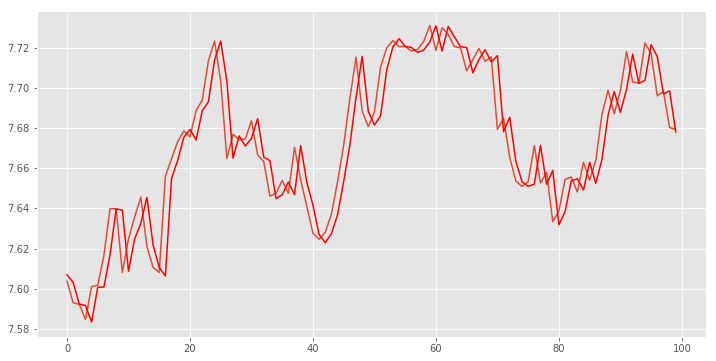

In [0]:
from sklearn.metrics import mean_squared_error

x = y.values
train_size = int(len(x) * 0.8)
train, test = x[0:train_size], x[train_size:]
history = [x for x in train]
predictions = []
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0][0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, actual=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test RMSE: %.3f' % np.sqrt(error))

plt.plot(test)
plt.plot(predictions, color='red')


In [0]:
result = pd.DataFrame(y)[train_size:]
result.columns = ["actual"]
result["prediction"] = predictions
result

,actual,prediction
Date,,
2019-03-22,7.603723,7.606943
2019-03-25,7.592996,7.603189
2019-03-26,7.592190,7.592348
2019-03-27,7.584722,7.591674
2019-03-28,7.601052,7.583432
2019-03-29,7.601727,7.600735
2019-04-01,7.616604,7.600800
2019-04-02,7.639787,7.616971
2019-04-03,7.639787,7.639738


In [0]:
from numpy import array
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [0]:
y_b = np.log(df["Close Price"])
y_b = y_b.asfreq("B").dropna()/10.0
print("%s" % y_b[:10])

ValueError: ignored

In [0]:
n_input = 5
train_size = int(0.7 * len(y_b))
y_b_train = y_b[:train_size]
y_b_test = y_b[train_size:]
generator_train = TimeseriesGenerator(y_b_train, y_b_train, length=n_input, batch_size=1, )
generator_test = TimeseriesGenerator(y_b_test, y_b_test, length=n_input, batch_size=1)
print('Samples: %d' % len(generator_train))
for i in range(3):
    x, y = generator_train[i]
    print('%s => %s' % (x, y))

Samples: 342
[[7.83550016 7.82306553 7.81981708 7.82268509 7.81895306]] => [7.8123175]
[[7.82306553 7.81981708 7.82268509 7.81895306 7.8123175 ]] => [7.81784684]
[[7.81981708 7.82268509 7.81895306 7.8123175  7.81784684]] => [7.82258494]


In [0]:
tf.set_random_seed(1)
np.random.seed(1)


model = keras.Sequential([
    keras.layers.InputLayer(input_shape = (n_input,)),
    keras.layers.Dense(1, activation = None, kernel_initializer = keras.initializers.he_uniform(seed = 1.0))
])
model.compile(loss = "mse", optimizer = keras.optimizers.SGD(lr = 0.1))
model.summary()

model.fit_generator(generator_train, steps_per_epoch=1, epochs=500, verbose=0)
y_b_test_pred = model.predict_generator(generator_test, use_multiprocessing = True)
layer = model.layers[0]
print(layer.get_weights())

W0827 08:10:42.962398 139666375608192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0827 08:10:42.963707 139666375608192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0827 08:10:42.976408 139666375608192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0827 08:10:43.011034 139666375608192 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0827 08:10:43.145092 139666375608192 deprecation_wrappe

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________
[array([[nan],
       [nan],
       [nan],
       [nan],
       [nan]], dtype=float32), array([nan], dtype=float32)]


In [0]:
y_b_test_pred.shape, y_b_test.shape

((145, 1), (150,))

In [0]:
metrics.mean_squared_error(y_b_test[n_input:] * 10.0, y_b_test_pred * 10.0) ** 0.5

ValueError: ignored

In [0]:
y_b = y_b_test_pred.flatten()
y_b = y_b_test_pred.reshape((len(y_b), 1))

train_size = int(0.7 * len(y_b))
y_b_train = y_b[:train_size]
y_b_test = y_b[train_size:]

n_input = 5

generator_train = TimeseriesGenerator(y_b_train, y_b_train, length=n_input, batch_size=1, )
generator_test = TimeseriesGenerator(y_b_test, y_b_test, length=n_input, batch_size=1)
print('Samples: %d' % len(generator_train))
for i in range(3):
    x, y = generator_train[i]
    print('%s => %s' % (x, y))


Samples: 96
[[[nan]
  [nan]
  [nan]
  [nan]
  [nan]]] => [[nan]]
[[[nan]
  [nan]
  [nan]
  [nan]
  [nan]]] => [[nan]]
[[[nan]
  [nan]
  [nan]
  [nan]
  [nan]]] => [[nan]]


In [0]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape = (n_input,1)),
    keras.layers.LSTM(units = 100),
    #keras.layers.Flatten(),
    keras.layers.Dense(units = 1, activation = None)
   

])
model.compile(loss = "mse", optimizer = "adam")
model.summary()

model.fit_generator(generator_train, steps_per_epoch=1, epochs=500, verbose=1)
y_b_test_pred = model.predict_generator(generator_test)
layer = model.layers[0]
#print(layer.get_weights())

W0827 08:10:58.015248 139666375608192 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
1/1 [==============================] - 1s 753ms/step - loss: nan
Epoch 2/500
1/1 [==============================] - 0s 11ms/step - loss: nan
Epoch 3/500
1/1 [==============================] - 0s 11ms/step - loss: nan
Epoch 4/500
1/1 [==============================] - 0s 11ms/step - loss: nan
Epoch 5/500
1/1 [==============================] - 0s 9ms/step - loss: nan
Epoch 6/500
1/1 [==============================] - 0s 9ms/step - loss: nan
Epoch 7/500
1/1 [==============================] - 0s 8ms/step - loss: nan
Epoc

In [0]:
y_b_test_pred.shape, y_b_test.shape

((39, 1), (44, 1))

In [0]:
metrics.mean_squared_error(y_b_test[n_input:] * 10.0, y_b_test_pred * 10.0) ** 0.5

0.020102595359782715